In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
os.listdir('../input/plant-pathology-2020-fgvc7')

['test.csv', 'sample_submission.csv', 'train.csv', 'images']

In [3]:
train = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')
train['image_id']=train['image_id']+'.jpg'
test['image_id']=test['image_id']+'.jpg'
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [4]:
img = []
filename = train.image_id
for file in filename:
    image = cv2.imread('../input/plant-pathology-2020-fgvc7/images/' + file)
    res = cv2.resize(image, (384, 384))
    img.append(res)
    
img = np.array(img)

In [5]:
print(img.shape)

(1821, 384, 384, 3)


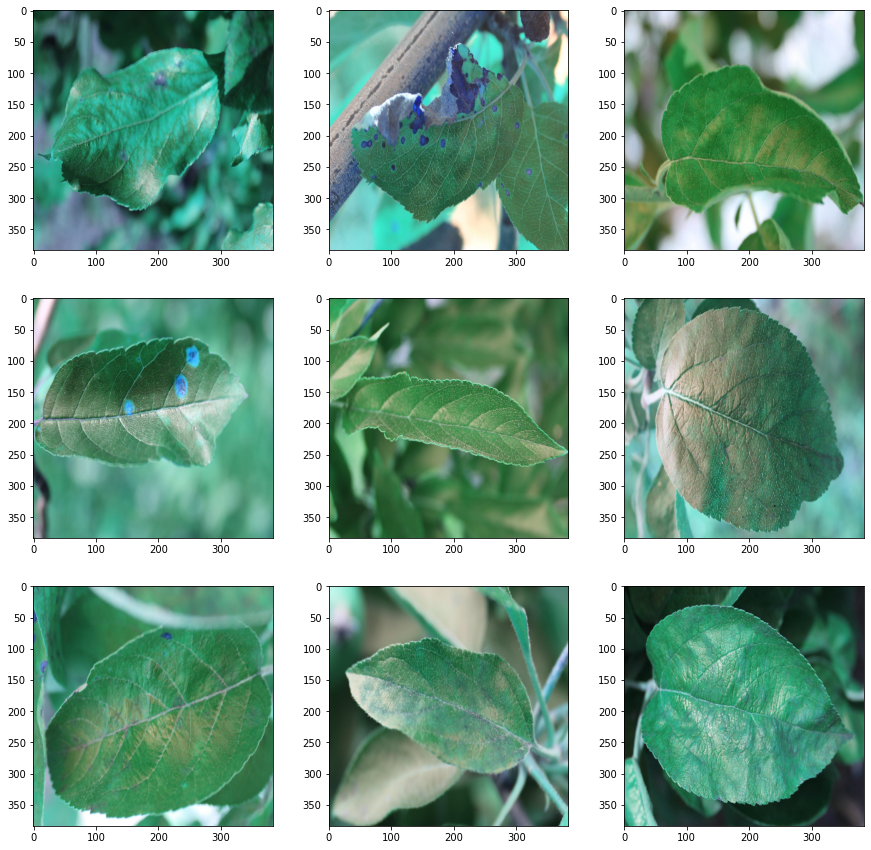

In [6]:
plt.figure(figsize = (15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i])

In [7]:
train_labels = np.float32(train.loc[:, 'healthy' : 'scab'].values)

train, val = train_test_split(train, test_size = 0.15)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,
    brightness_range=[0.5, 1.5])

In [9]:
train_generator=train_datagen.flow_from_dataframe(train,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                       subset='training',
                                                      batch_size=16)


Found 1547 validated image filenames.


In [10]:
val_generator=train_datagen.flow_from_dataframe(val,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=16,
                                                  )

Found 274 validated image filenames.


In [11]:
test_generator=train_datagen.flow_from_dataframe(test,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=16)

Found 1821 validated image filenames.


In [12]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(384,384,3))
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



94658560/94653016 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 390, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 192, 192, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 192, 192, 64) 256         conv1[0][0]                      
___________________________

In [13]:
from keras.callbacks import ReduceLROnPlateau

In [14]:
history_1 = model_finetuned.fit_generator(train_generator,                                    
                                  steps_per_epoch=100, 
                                  epochs=25,validation_data=val_generator,validation_steps=100
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)])

Epoch 1/25
100/100 [==============================] - 272s 3s/step - loss: 0.8551 - accuracy: 0.6934 - val_loss: 2.7729 - val_accuracy: 0.2935
Epoch 2/25
100/100 [==============================] - 235s 2s/step - loss: 0.4871 - accuracy: 0.8495 - val_loss: 2.0010 - val_accuracy: 0.2988
Epoch 3/25
100/100 [==============================] - 232s 2s/step - loss: 0.4256 - accuracy: 0.8683 - val_loss: 2.5110 - val_accuracy: 0.2908
Epoch 4/25
100/100 [==============================] - 230s 2s/step - loss: 0.3669 - accuracy: 0.8915 - val_loss: 2.9064 - val_accuracy: 0.2988
Epoch 5/25
100/100 [==============================] - 228s 2s/step - loss: 0.3218 - accuracy: 0.9041 - val_loss: 6.3801 - val_accuracy: 0.3190
Epoch 6/25
100/100 [==============================] - 230s 2s/step - loss: 0.2510 - accuracy: 0.9260 - val_loss: 1.9930 - val_accuracy: 0.2975
Epoch 7/25
100/100 [==============================] - 229s 2s/step - loss: 0.2194 - accuracy: 0.9342 - val_loss: 4.6771 - val_accuracy: 0.2948

In [15]:
fig = go.Figure(data=[
    go.Line(name='train_acc', x=history_1.epoch, y=history_1.history['accuracy']),
    go.Line(name='Val_acc', x=history_1.epoch, y=history_1.history['val_accuracy'])])

fig.update_layout(
    title="Accuracy",
    xaxis_title="epoch",
    yaxis_title="accuracy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ))
fig

/opt/conda/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
probs_RESNET = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv('submission_RESNET.csv', index=False)
sub.head()